### Используемые технологии

Для реализации проекта были использованы следующие библиотеки и инструменты:

- **OpenCV**: Библиотека для компьютерного зрения, используемая для загрузки изображений, распознавания лиц и глаз, а также для применения размытия.
- **Requests**: Библиотека для выполнения HTTP-запросов, используемая для загрузки изображений из интернета.
- **PIL (Python Imaging Library)**: Библиотека для работы с изображениями, используемая для преобразования изображений.
- **NumPy**: Библиотека для работы с массивами, используемая для преобразования изображений в массивы.
- **Matplotlib**: Библиотека для визуализации данных, используемая для отображения исходного и обработанного изображений.



In [80]:
import cv2
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from matplotlib import pyplot

Функция данная в условии задачи

In [81]:
# Функция для размытия лица
def blur_face(img):
    (h, w) = img.shape[:2]
    dW = int(w / 3.0)
    dH = int(h / 3.0)
    if dW % 2 == 0:
        dW -= 1
    if dH % 2 == 0:
        dH -= 1
    return cv2.GaussianBlur(img, (dW, dH), 0)

**Загрузка изображения**:
   - Изображение загружается из интернета по указанному URL.
   - Изображение преобразуется в формат, подходящий для работы с OpenCV.

In [82]:
# URL изображения
image_url = 'https://static.kinoafisha.info/k/articles/1200/upload/articles/421010603361.jpg'

# Загрузка изображения из интернета
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img2 = img.copy()

In [83]:
# Загрузка каскада Хаара для распознавания лиц
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Загрузка каскада Хаара для распознавания глаз
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

# Распознавание лица
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

1. **Распознавание лиц**:
   - Используется каскад Хаара для распознавания лиц (`haarcascade_frontalface_default.xml`).
   - Лица распознаются на изображении, и для каждого лица определяются координаты области.

2. **Распознавание глаз**:
   - Внутри каждой области лица распознаются глаза с использованием каскада Хаара для глаз (`haarcascade_eye.xml`).
   - Координаты центров глаз сохраняются для дальнейшего использования.

3. **Размытие лица**:
   - Лицо размывается с использованием Гауссова размытия, исключая области глаз.
   - Области глаз остаются неизменными.



```face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)):```

- img: Исходное изображение, на котором производится поиск лиц.
- scaleFactor=1.1: Коэффициент масштабирования изображения на каждом уровне пирамиды изображений.
- minNeighbors=5: Минимальное количество соседей, необходимое для подтверждения распознавания лица.
- minSize=(30, 30): Минимальный размер окна, в котором производится поиск лиц.

```eyes = eye_cascade.detectMultiScale(face, scaleFactor=1.1, minNeighbors=10, minSize=(15, 15))```


- face: Область лица, в которой производится поиск глаз.
- scaleFactor=1.1: Коэффициент масштабирования изображения на каждом уровне пирамиды изображений.
- minNeighbors=10: Минимальное количество соседей, необходимое для подтверждения распознавания глаза.
- minSize=(15, 15): Минимальный размер окна, в котором производится поиск глаз.


```center_coordinates = (x + ex + ew // 2, y + ey + eh // 2):```

- x, y: Координаты верхнего левого угла области лица.
- ex, ey: Координаты верхнего левого угла области глаза относительно области лица.
- ew, eh: Ширина и высота области глаза.
- center_coordinates: Координаты центра глаза.

```radius = ew // 2:```

- radius: Радиус глаза, равный половине его ширины.

In [84]:
for (x, y, w, h) in faces:
    # Область лица
    face = img2[y:y + h, x:x + w]

    # Распознавание глаз внутри области лица
    eyes = eye_cascade.detectMultiScale(face, scaleFactor=1.1, minNeighbors=10, minSize=(15, 15))
    eye_centers = []
    for (ex, ey, ew, eh) in eyes:
        # Сохранение координат центров глаз
        center_coordinates = (x + ex + ew // 2, y + ey + eh // 2)
        radius = ew // 2
        eye_centers.append((center_coordinates, radius))

    # Проверка, что распознано два глаза
    if len(eye_centers) == 2:
        # Размытие лица, исключая области глаз
        for (ex, ey), radius in eye_centers:
            eye_area = img2[ey - radius:ey + radius, ex - radius:ex + radius]
            img2[ey - radius:ey + radius, ex - radius:ex + radius] = blur_face(eye_area)

        face_blurred = blur_face(face)
        img2[y:y + h, x:x + w] = face_blurred
        for (ex, ey), radius in eye_centers:
            eye_area = img[ey - radius:ey + radius, ex - radius:ex + radius]
            img2[ey - radius:ey + radius, ex - radius:ex + radius] = eye_area

        # Рисование овала вокруг лица после размытия
        center_coordinates = (x + w // 2, y + h // 2)
        axes_length = (int((w // 2) * 0.8), int((h // 2) * 1.15))  # Увеличиваем высоту овала
        angle = 0
        start_angle = 0
        end_angle = 360
        color = (255, 0, 0)
        thickness = 2
        cv2.ellipse(img2, center_coordinates, axes_length, angle, start_angle, end_angle, color, thickness)

        # Рисование кружков вокруг глаз
        for (ex, ey), radius in eye_centers:
            color = (0, 255, 0)
            thickness = 2
            cv2.circle(img2, (ex, ey), radius, color, thickness)

4. **Визуализация результатов**:
   - Оригинальное и обработанное изображения отображаются с использованием Matplotlib.
   - Вокруг лиц рисуются овалы, а вокруг глаз — кружки.

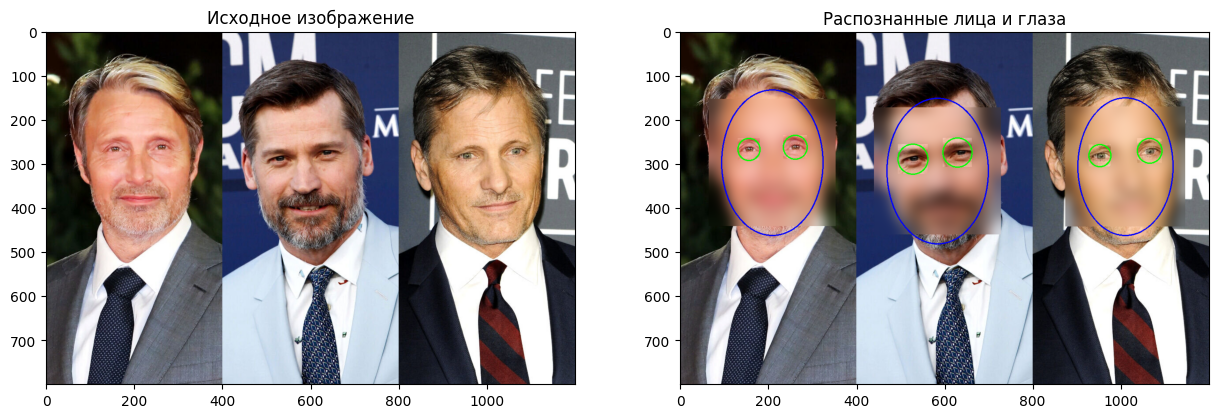

In [85]:
# Отображение результата
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Исходное изображение')
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Распознанные лица и глаза')
pyplot.show()